In [18]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpltools import color
import numpy as np
from scipy import optimize
import os
import DSH
from DSH import Kernel
from DSH import MIfile as MI
from DSH import MIstack as MIs
from DSH import IOfunctions as iof
from DSH import SALS as LS

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger = logging.getLogger('matplotlib')
logger.setLevel(logging.WARNING)
logging.info('SALS tutorial started')

INFO:root:SALS tutorial started


# Small Angle Light Scattering (SALS) analysis

### 1. Open SALS results

DEBUG:root:MIfile object created with filename E:\Louanne\241114_CS0.8AA1_32deg_2\AGED\000_SLS_AGED.raw
DEBUG:root:MIfile - Metadata filename automatically generated: E:\Louanne\241114_CS0.8AA1_32deg_2\AGED\000_SLS_AGED_metadata.ini
DEBUG:root:Now loading MIfile metadata (from filename: E:\Louanne\241114_CS0.8AA1_32deg_2\AGED\000_SLS_AGED_metadata.ini)
DEBUG:root:Loading config file E:\Louanne\241114_CS0.8AA1_32deg_2\AGED\000_SLS_AGED_metadata.ini (1 sections, 6 keys)
DEBUG:root:Now loading MIfile.MetaData from Config object. Available sections: ['MIfile']


['Img', 'Series', 'Exptime[ms]', 'TimeSet[s]', 'TimeElapsed_0[s]', 'TimeRun_0[s]', 'jitter_0[us]', 'FrameProcessed_0[s]', 'ProcessDelay_0[us]']


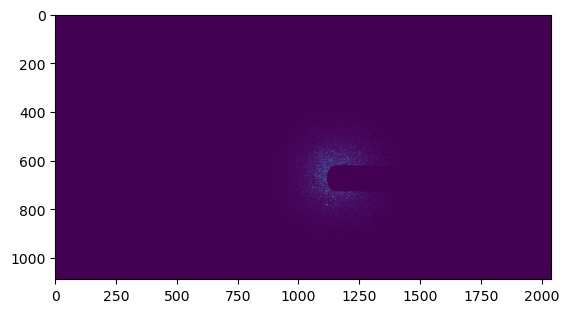

In [19]:
#---------------------------------
froot = r'E:\Louanne\241114_CS0.8AA1_32deg_2\AGED'
fname_prefix = '000_SLS_AGED'
#---------------------------------


imgTimes, imgTimes_hdr = iof.LoadResFile(os.path.join(froot, fname_prefix+'_imgTimes.dat'), readHeader=True, isolateFirst=0, delimiter='\t', comments='#', missing_values='-')
print(imgTimes_hdr)

MIinput = MI.MIfile(os.path.join(froot, fname_prefix+'.raw'))
MIinput.OpenForReading()
plt.imshow(MIinput.GetImage(0))

### 2. Initialize SALS object

DEBUG:root:Appending input dictionary to section ROIs
INFO:root:Set 1 valid ROIs
DEBUG:root:195 image times loaded (Image number: 195)
DEBUG:root:Set 65 exptimes, sorted from 0.002 to 20.0
DEBUG:root:MaskCoords created with
	- 100 first coords from 42.73 (+- 0.73) to 1278.07 (+- 21.93) and
	- 1 second coords from 0.0 (+- 3.15) to 0.00 (+- 3.15)
DEBUG:root:100 binary masks created with shape (1088, 2040)
DEBUG:root:Appending input dictionary to section ROIs
DEBUG:root:ROI 0 is empty
DEBUG:root:ROI 1 is empty



|-----------------|
|   SALS class:   |
|-----------------+---------------
| Input           : MIfile (E:\Louanne\241114_CS0.8AA1_32deg_2\AGED\000_SLS_AGED.raw), 195 images
| Center position : [1165, 656]
| ROIs            : 100 (98 valid, 2 empty)
| Exposure times  : 65, from 0.002 to 20.0
|-----------------+---------------


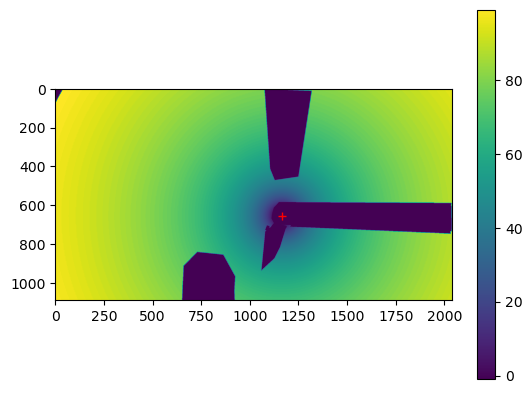

In [21]:
#---------------------------------
px_mask = MI.ReadBinary(os.path.join(froot, 'mask.raw'), MIinput.ImageShape(), 'B') # <-- mask to be drawn for each experiment
ROIs = [np.geomspace(42, 1300, 101), None] # <-- [radial_intervals, angular_intervals]
center_pos = [1165, 656] # <-- transmitted beam position to be updated each experiment
#---------------------------------

Img_times = iof.LoadImageTimes(os.path.join(froot, fname_prefix+'_imgTimes.dat'), usecols=3, skiprows=1)
exp_times = iof.LoadImageTimes(os.path.join(froot, fname_prefix+'_imgTimes.dat'), usecols=2, skiprows=1)
SALS_analyzer = LS.SALS(MIinput, centerPos=center_pos, ROIslices=ROIs, maskRaw=px_mask, imgTimes=Img_times, expTimes=exp_times)

print(SALS_analyzer)
plt.imshow(SALS_analyzer.ROIs)
plt.plot(*SALS_analyzer.centerPos, 'r+')
plt.colorbar()

### 4. SLS/DLS analysis

In [22]:
%%time
ROIavgs_allExp, ROIavgs_best, BestExptime_Idx, buf_images = SALS_analyzer.doSLS(os.path.join(froot, fname_prefix))

Created folder: E:\Louanne\241114_CS0.8AA1_32deg_2\AGED\000_SLS_AGED


INFO:root:ROIproc configuration exported to folder E:\Louanne\241114_CS0.8AA1_32deg_2\AGED\000_SLS_AGED
C:\Users\RHEODLS\Documents\GitHub\DSHpy\DSH\ROIproc.py:300: RuntimeWarning: invalid value encountered in divide
  ROI_avg = np.array([[np.true_divide(np.sum(np.multiply(use_img[i][rbb[b][0]:rbb[b][2],rbb[b][1]:rbb[b][3]], ROIboolMask[b]),
DEBUG:root:ROIproc.doSLS: output saved
DEBUG:root:ROIproc.doSLS analysis returned: raw data (shape: (3, 65, 100)), Iavg data (shape: (3, 100)), exptime data (shape: (3, 100)), buffer images (shape (195, 1088, 2040))


CPU times: total: 1min 14s
Wall time: 1min 14s


In [27]:
%%time
SALS_analyzer.doDLS(os.path.join(froot, fname_prefix), lagtimes=[1, 2, 4, 10, 20, 40, 100, 200, 400])

Created folder: G:\241108_LenorSLS\05_0.3perc_bis\002_DLS_SMALLQ


INFO:root:ROIproc.doDLS Analysis started! Input data is 1000 images (1000 times, 1 exposure times)
INFO:root:Analysis will resolve 6 ROIs and DLS will be performed on 1000 reference times and 10 lagtimes. Output will be saved in folder G:\241108_LenorSLS\05_0.3perc_bis\002_DLS_SMALLQ
INFO:root:Now starting with SLS...
DEBUG:root:ROIproc.doSLS: output saved
DEBUG:root:ROIproc.doSLS analysis returned: raw data (shape: (1000, 1, 6)), Iavg data (shape: (1000, 6)), exptime data (shape: (1000, 6)), buffer images (shape (1000, 986, 1023))
INFO:root:SLS analysis completed. Now doing DLS (1 exposure times, 1000 time points, 10 lagtimes)
INFO:root:Now performing DLS on 0-th exposure time. Using image range [0, 1000, 1] (1000 images)
INFO:root:Contrast (d0) processed
INFO:root:Lagtime 1/9 (d1) completed
INFO:root:Lagtime 2/9 (d2) completed
INFO:root:Lagtime 3/9 (d4) completed
INFO:root:Lagtime 4/9 (d10) completed
INFO:root:Lagtime 5/9 (d20) completed
INFO:root:Lagtime 6/9 (d40) completed
INFO:roo

Wall time: 9min 31s


### 5. Visualizing analysis output

DEBUG:root:DSH.IOfunctions.OpenG2M1s: 6 g2-1 functions loaded from 6 ROIs found in folder G:\241108_LenorSLS\05_0.3perc_bis\002_DLS_SMALLQ


Text(0, 0.5, '$g_2-1$')

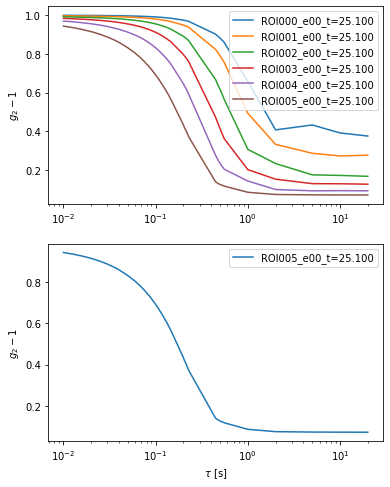

In [28]:
g2m1_data, lagtimes, imgtimes, ROI_list, exptime_list = iof.OpenG2M1s(os.path.join(froot, fname_prefix))
fig, ax = plt.subplots(nrows=2, figsize=(6, 8))
tidx=0
for i in range(len(g2m1_data)):
    ax[0].plot(lagtimes[i][tidx][1:], g2m1_data[i][tidx][1:], label='ROI'+str(ROI_list[i]).zfill(3)+'_e'+str(exptime_list[i]).zfill(2)+'_t={0:.3f}'.format(imgtimes[i][tidx]))
ax[0].set_xscale('log')
ax[0].legend()
ridx=-1
for i in range(len(g2m1_data[ridx])):
    ax[1].plot(lagtimes[ridx][i][1:], g2m1_data[ridx][i][1:], label='ROI'+str(ROI_list[ridx]).zfill(3)+'_e'+str(exptime_list[ridx]).zfill(2)+'_t={0:.3f}'.format(imgtimes[ridx][i]))
ax[1].set_xscale('log')
ax[1].legend()
ax[1].set_xlabel(r'$\tau$ [s]')
ax[0].set_ylabel(r'$g_2-1$')
ax[1].set_ylabel(r'$g_2-1$')

### 6: Run from config file

DEBUG:root:Loading config file U:\230606_testDLS\out\SALSconfig_modif.ini (8 sections, 40 keys)
DEBUG:root:Config.LoadConfig() assuming that input is of Config type (8 sections)
INFO:root:ROIproc.LoadFromConfig reading configuration from Config object (8 sections) -- Root folder: U:\230606_testDLS\out -- version 2.0, generated by SALS.doDLS on 06/08/2023, 11:46:39
DEBUG:root:MIfile object created with filename U:\230606_testDLS\007_DLS.raw
DEBUG:root:Now loading MIfile metadata (dict with 8 keys)
DEBUG:root:Appending input dictionary to section MIfile
DEBUG:root:Now loading MIfile.MetaData from Config object. Available sections: ['MIfile', 'settings']
DEBUG:root:ROIproc.LoadFromConfig loading MIfile U:\230606_testDLS\007_DLS.raw (metadata: {'hdr_len': '0', 'px_format': 'B', 'fps': '10', 'px_size': '1', 'shape': '[240, 1088, 2040]', 'comments': 'filename: D:\\Data\\Louanne\\230606\\007_DLS_metadata.ini', 'is_stack': 'False', 'filename': 'U:\\230606_testDLS\\007_DLS.raw'})
DEBUG:root:ROI

Created folder: U:\230606_testDLS\out\reproc


INFO:root:ROIproc.doDLS Analysis started! Input data is 240 images (240 times, 1 exposure times)
INFO:root:Analysis will resolve 4 ROIs and DLS will be performed on 240 reference times and 12 lagtimes. Output will be saved in folder U:\230606_testDLS\out\reproc
INFO:root:Now starting with SLS...
DEBUG:root:ROIproc.doSLS: output saved
DEBUG:root:ROIproc.doSLS analysis returned: raw data (shape: (240, 1, 4)), Iavg data (shape: (240, 4)), exptime data (shape: (240, 4)), buffer images (shape (240, 1088, 1455))
INFO:root:SLS analysis completed. Now doing DLS (1 exposure times, 240 time points, 12 lagtimes)
INFO:root:Now performing DLS on 0-th exposure time. Using image range [0, 240, 1] (240 images)
INFO:root:Contrast (d0) processed
INFO:root:Lagtime 1/11 (d1) completed
INFO:root:Lagtime 2/11 (d2) completed
INFO:root:Lagtime 3/11 (d4) completed
INFO:root:Lagtime 4/11 (d6) completed
INFO:root:Lagtime 5/11 (d8) completed
INFO:root:Lagtime 6/11 (d12) completed
INFO:root:Lagtime 7/11 (d18) comp


|-----------------|
|   SALS class:   |
|-----------------+---------------
| Input           : MIfile (U:\230606_testDLS\007_DLS.raw), 240 images
| Center position : [1885, 786]
| ROIs            : 4 (4 valid, 0 empty)
| Exposure times  : 1, from 0.1 to 0.1
|-----------------+---------------
Wall time: 1min 8s


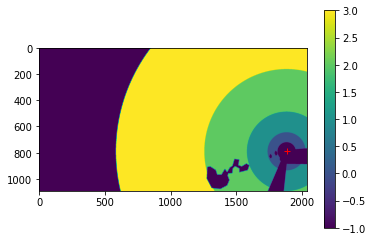

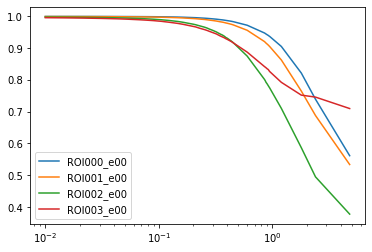

In [15]:
%%time

SALS_reload = LS.LoadFromConfig(os.path.join(froot, 'out', 'SALSconfig_modif.ini'))

print(SALS_reload)
plt.imshow(SALS_reload.ROIs)
plt.plot(*SALS_reload.centerPos, 'r+')
plt.colorbar()

g2m1_data, lagtimes, imgtimes, ROI_list, exptime_list = iof.OpenG2M1s(os.path.join(froot, 'out', 'reproc'))
fig, ax = plt.subplots()
for i in range(len(g2m1_data)):
    ax.plot(lagtimes[i][0][1:], g2m1_data[i][0][1:], label='ROI'+str(ROI_list[i]).zfill(3)+'_e'+str(exptime_list[i]).zfill(2))
ax.set_xscale('log')
ax.legend()